In [ ]:
import pandas as pd
import os
import numpy as np
import gspread
import glob
import seaborn as sns
from tqdm import tqdm


# Goal
1. For each city/state/country, we extract num_person_killed_lahk, daly at 2019
2. For each city, we extract daly at 2015 and 2019 for temporal analysis
3. For each city, we extract num_person_killed_lahk at 2016 section and 2019 section for temporal analysis
we test the relationship between presence of sidewalk per h3 level 6, 9, 12 index and dalys

* Note. Dependent variables are DALYs, num_person_killed_lahk (2019). India, US, Brazil, Hong Kong, Taipei should not use the WHO data. India (2018-2022 only); Brazil (2019 only). 

In [38]:
def load_all():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    city_meta["city_lower"] = city_meta["City"].apply(lambda x: x.lower().replace(" ", ""))
    return city_meta

In [39]:
TRANS_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_transformed/"
TRANS_PATHS = {"dalys":"t_road_dalys/t_dalys_no_weight.csv", 
               "fatality":"t_road_fatality/t_fatality_country_state_county_year.csv"}


CURATED_FOLDER_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional"
CURATED_FOLDER_LONG = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_longitudinal"

CURATED_PANO_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_crossectional"
CURATED_PANO_LONG = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_longitudinal"

EXPORT_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_analysis"

Y2 = '2020-2023'
Y1 = '2015-2018'


In [40]:
if not os.path.exists(EXPORT_FOLDER):
    os.makedirs(EXPORT_FOLDER)
dalys = pd.read_csv(os.path.join(TRANS_FOLDER, TRANS_PATHS["dalys"]))
dalys["city_lower"] = dalys["city"].apply(lambda x: x.lower().replace(" ", ""))
fatality = pd.read_csv(os.path.join(TRANS_FOLDER, TRANS_PATHS["fatality"]))

In [41]:
h3_res = [6, 9, 12]
city_meta = load_all()

In [42]:
sely_fatality = ['num_person_killed_per_lakh', 'num_person_killed']

fatality_19 = fatality[fatality['year'].isin([2019,2020,2021,2022])].reset_index(drop = True)
fatality_19['year_group'] = Y2
fatality_16 = fatality[fatality['year'].isin([2014, 2015,2016, 2017])].reset_index(drop = True)
fatality_16['year_group'] = Y1
fatality_16['City'].nunique()
fatality_long = pd.concat([fatality_19, fatality_16]).reset_index(drop = True)
fatality_long['num_person_killed'] = fatality_long['num_person_killed'].apply(lambda x: float(x.replace(",", "")))

fatality_long = fatality_long[["year_group", 'City', 'Country', 'country_clean','State/Province', 'city_lower','num_fatal_accidents',
       'num_person_killed', 'num_accidents', 'num_person_killed_per_lakh',]].groupby(
    ["year_group", 'City', 'Country','country_clean', 'State/Province', 'city_lower']).mean().reset_index()

dalys['year_group'] = np.where(dalys['year'].isin([2019,2020,2021,2022]), '2020-2023', '2015-2018')
dalys['year_group'].unique()
dalys.columns

Index(['city', 'city_clean', 'country_clean', 'urban_pop', 'pop_country',
       'year', 'diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap', 'road_injury_5-14_cap', 'road_injury_15-29_cap',
       'city_lower', 'year_group'],
      dtype='object')

In [12]:
# Brazil Daly, can be used for other cases analysis later
# brazil_daly = \
# fatality[(fatality['country']=='Brazil')&(fatality["source"]!="WHO")&(fatality["state"]!="Brazil")].reset_index()[['state','year','DALY Rate']].rename(
#     columns = {'DALY Rate':'road_injury_cap'})
# brazil = \
# dalys[(dalys['country_clean']=='Brazil')&(dalys['year']==2019)][['city','city_clean','country_clean','urban_pop']]\
# .merge(city_meta[city_meta["Country"]=="Brazil"][["City","State/Province"]],
#        right_on = "City",
#        left_on = "city")\
# .merge(brazil_daly, right_on = "state", left_on = "State/Province").drop(["state", "City"], axis = 1)


## 0. Process segmentation

In [54]:
# seg_problem_city = ["Nagoya", "Lima", "Rio de Janeiro","Dhaka"] # seg problems
# pano_problem_city = ["Rome", "Dehli"]+seg_problem_city
# pano_problem_city_lower = [x.lower().replace(" ", "") for x in pano_problem_city]

sely = ["country_clean",'urban_pop', 'pop_country', 'diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap','road_injury_5-14_cap', 'road_injury_15-29_cap', 'city_lower']

def get_cross(curated_cross = CURATED_FOLDER_CROSS):
    segfiles = glob.glob(curated_cross+"/*.parquet")
    df_seg = []
    for f in tqdm(segfiles):
        temp = pd.read_parquet(f)
        temp["city_lower"] = f.split("/")[-1].split(".")[0]
        df_seg.append(temp)
    df_seg = pd.concat(df_seg).reset_index(drop = True)
    return df_seg

def get_long(curated_long = CURATED_FOLDER_LONG):
    segfiles = glob.glob(curated_long+"/*.parquet")
    df_seg_long = []
    for f in tqdm(segfiles):
        temp = pd.read_parquet(f)
        temp["city_lower"] = f.split("/")[-1].split(".")[0]
        df_seg_long.append(temp)
    df_seg_long = pd.concat(df_seg_long).reset_index(drop = True)
    return df_seg_long
    


In [44]:
df_seg = get_cross(CURATED_FOLDER_CROSS)
df_pano = get_cross(CURATED_PANO_CROSS)
df_seg_long = get_long(CURATED_FOLDER_LONG)
df_pano_long = get_long(CURATED_PANO_LONG)

100%|██████████| 127/127 [00:08<00:00, 14.18it/s]


In [45]:
df_seg = df_seg.groupby(['hex_id','res','city_lower']).mean().reset_index()
df_pano = df_pano.groupby(['hex_id','res','city_lower']).mean().reset_index()

In [47]:
df_seg_long = df_seg_long.groupby(['hex_id','res','city_lower','year_group']).mean().reset_index()
df_pano_long = df_pano_long.groupby(['hex_id','res','city_lower','year_group']).mean().reset_index()

In [46]:
# count number of people, car, furniture using the pano file
panocity = df_pano["city_lower"].unique()
segcity = df_seg['city_lower'].unique()
remain = [x for x in segcity if x not in panocity]
remain

[]

## 1. Generate crossectional first 

In [48]:
dalys['year'].unique() # change the 2015 to 2016 for the dalys estimation so that the data can map
year_group1 = [2015,2016,2017,2018]
year_group2 = [2019, 2020, 2021, 2022]
# fatality_sel_year = [2016, 2019]
# since DALY only has till 2019 data
# fatality, select the 2016 and 2019, world data only availiable till 2019
fatality_19 = fatality_long[fatality_long['year_group']==Y2].reset_index(drop = True)
fatality_16 = fatality_long[fatality_long['year_group']==Y1].reset_index(drop = True)

In [55]:

seg_sample = df_seg\
    .merge(df_pano, on = ['city_lower', 'hex_id'], 
           how = 'left', 
           suffixes = ['', '_count']).fillna(0)\
    .merge(dalys[dalys["year_group"]== '2020-2023'][sely], 
                       on = 'city_lower', how = 'left')\
    .merge(fatality_19[sely_fatality+["city_lower"]], 
                       on = 'city_lower', how = 'left')

print(seg_sample["city_lower"].nunique(), " cities processed.")

yls = ['diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap','road_injury_5-14_cap', 'road_injury_15-29_cap']
xls = ['building', 'greenery', 'street_furniture',
       'sidewalk', 'car', 'person', 'bike', 'sky', 'road']
logxls = ["log_"+x for x in xls]
logyls = ["log_"+x for x in yls]
for x in xls+yls:
    seg_sample["log_"+x] = np.log(seg_sample[x]+1)

127  cities processed.


<Axes: xlabel='road', ylabel='car_count'>

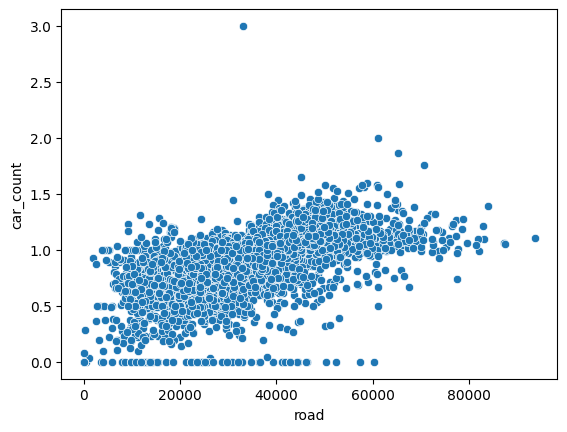

In [50]:
sns.scatterplot(
    data = seg_sample[seg_sample["res"]==6],
    x = "road",
    y = "car_count",
    # hue = "Country"
)

In [56]:
seg_sample.columns

Index(['hex_id', 'res', 'city_lower', 'img_count', 'building', 'greenery',
       'street_furniture', 'sidewalk', 'car', 'person', 'bike', 'sky', 'road',
       'res_count', 'street_furniture_count', 'car_count', 'person_count',
       'bike_count', 'country_clean', 'urban_pop', 'pop_country',
       'diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap',
       'road_injury_5-14_cap', 'road_injury_15-29_cap',
       'num_person_killed_per_lakh', 'num_person_killed', 'log_building',
       'log_greenery', 'log_street_furniture', 'log_sidewalk', 'log_car',
       'log_person', 'log_bike', 'log_sky', 'log_road',
       'log_diabetes_mellitus_cap',
       'log_mental_and_substance_use_disorders_cap',
       'log_cardiovascular_diseases_cap', 'log_road_injury_cap',
       'log_road_injury_5-14_cap', 'log_road_injury_15-29_cap'],
      dtype='object')

In [57]:
seg_sample[seg_sample["res"].isin([6,9])].to_csv(os.path.join(EXPORT_FOLDER, "01_seg_dalys_cross.csv"), index = False)

In [25]:
seg_sample[seg_sample["res"].isin([6,9])].shape # 571963

(571963, 40)

## 2. Analyze the fatality (number person killed by 100_000 population)
### 2.a Match years

In [26]:
df_seg_long['hex_year_group_count'] = df_seg_long.groupby(["hex_id", "year_group"])["year_group"].transform("count")
df_seg_long[df_seg_long['hex_year_group_count']>1]

cat,hex_id,res,city_lower,year_group,img_count,building,greenery,street_furniture,sidewalk,car,person,bike,sky,road,hex_year_group_count
1642,861fa41a7ffffff,6,antwerp,2015-2018,5612.0,34453.384711,30301.340699,114.348717,10122.552210,9600.133820,84.556664,112.955453,58695.024768,63746.629187,2
1643,861fa41a7ffffff,6,antwerp,2020-2023,10116.0,34238.362495,30075.489719,110.341242,10620.981020,9164.562772,94.608640,154.671807,61670.325227,64845.223408,2
1644,861fa41a7ffffff,6,brussels,2015-2018,2532.0,23104.413112,27350.195893,74.958136,8305.718404,5939.808057,45.467220,51.513428,50653.419826,45708.022907,2
1645,861fa41a7ffffff,6,brussels,2020-2023,1416.0,27397.030367,23498.123588,64.437147,8144.026130,5803.735169,39.794492,64.161017,51606.752119,49163.567090,2
1648,861fa41b7ffffff,6,antwerp,2015-2018,4776.0,28374.142379,36759.482621,107.249581,9571.853853,7812.099246,63.685930,98.638400,55550.909129,64741.341080,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786856,8c694ec35b4d3ff,12,metromanila,2015-2018,4.0,78368.250000,0.000000,0.000000,2199.250000,7017.750000,367.250000,10734.750000,18325.750000,36732.000000,2
6786868,8c694ec35b58dff,12,manila,2015-2018,4.0,26111.250000,959.500000,0.000000,2113.000000,1331.750000,515.750000,3906.000000,61112.000000,57559.500000,2
6786869,8c694ec35b58dff,12,metromanila,2015-2018,4.0,24814.750000,6.000000,0.000000,821.000000,19796.750000,363.250000,661.500000,61509.250000,46746.500000,2
6786892,8c694ec35b76dff,12,manila,2020-2023,4.0,32590.000000,9439.250000,0.000000,6577.750000,4228.000000,0.750000,36.250000,45888.000000,55509.750000,2


In [58]:
seg_sample_fatality = df_seg_long\
            .merge(df_pano_long, on = ['hex_id','res','city_lower', 'year_group'],
                   suffixes = ['', '_count'], how = 'left').fillna(0)\
            .merge(fatality_long[sely_fatality+["city_lower","year_group"]], 
                   on = ['city_lower', 'year_group'], how = 'left')\
            .merge(dalys, on = ['city_lower', 'year_group'], how = 'left')
print(
    seg_sample_fatality.groupby("year_group")["city_lower"].nunique(), 
      " cities processed.")


year_group
2015-2018    115
2020-2023    118
Name: city_lower, dtype: int64  cities processed.


(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

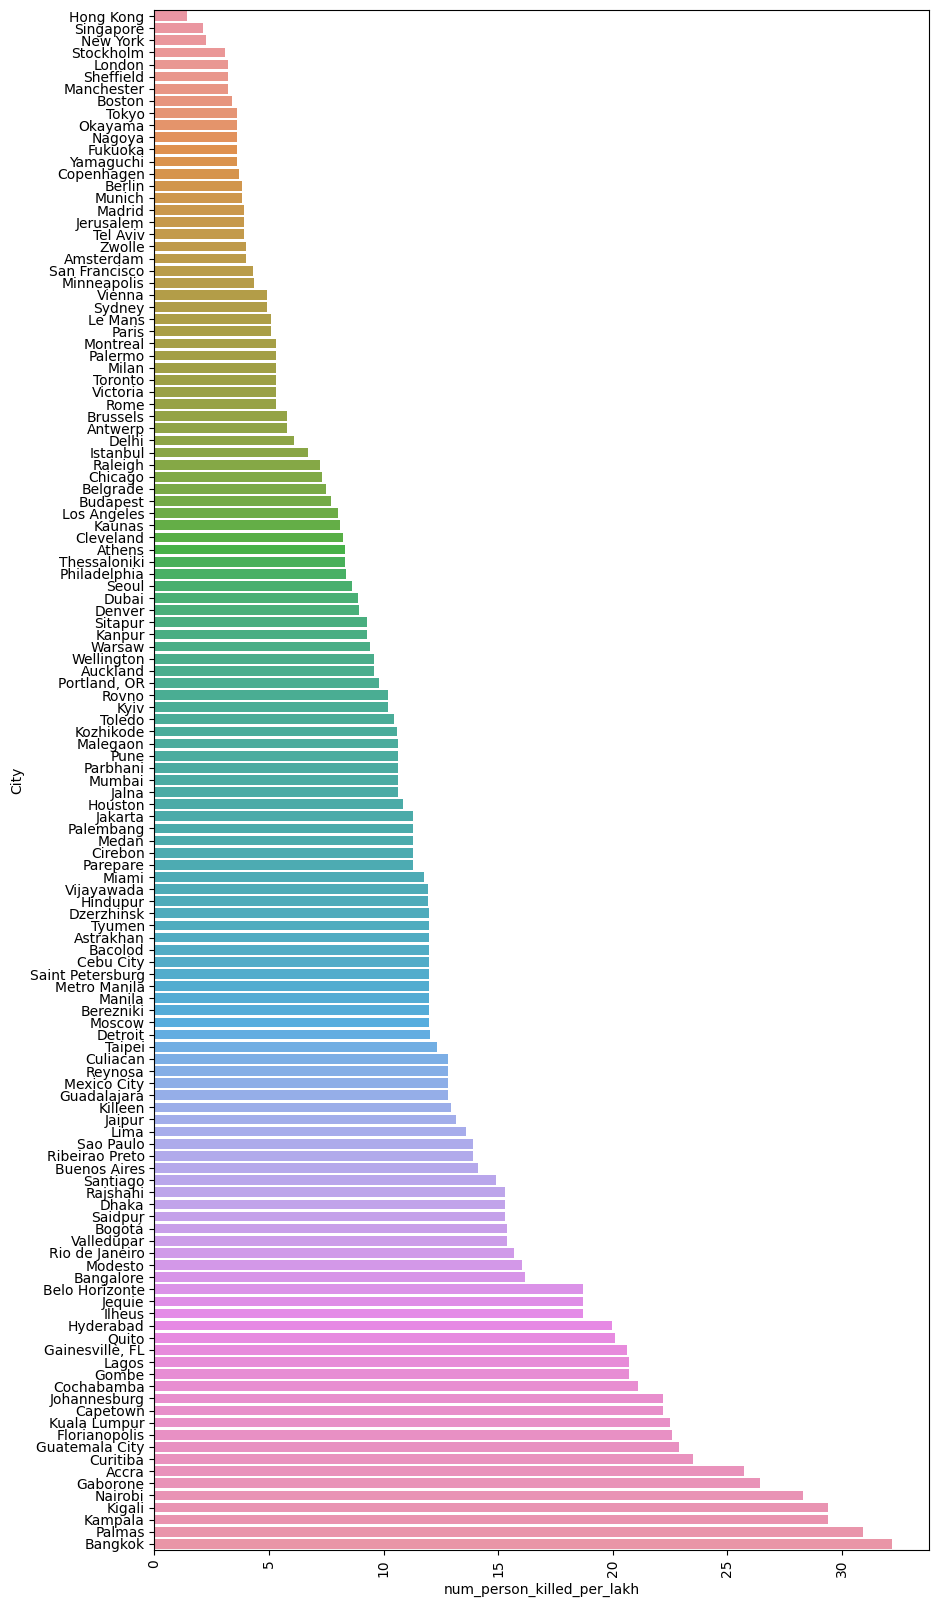

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,20))
sns.barplot(
    data = fatality_19.sort_values("num_person_killed_per_lakh"),
    y = "City",
    x = "num_person_killed_per_lakh"
)
plt.xticks(rotation=90)

<Axes: xlabel='sidewalk', ylabel='num_person_killed_per_lakh'>

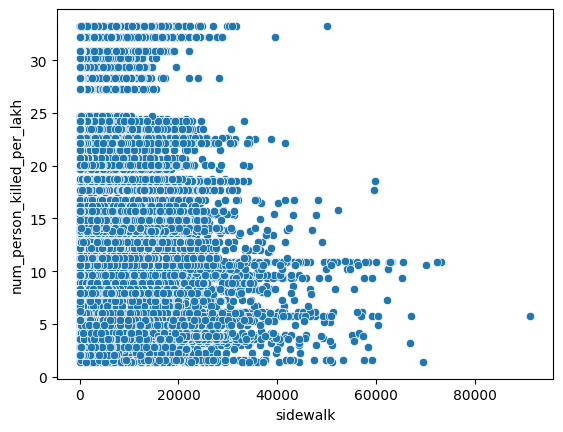

In [33]:
sns.scatterplot(
    data = seg_sample_fatality[(seg_sample_fatality["res"]==9)],
    x = "sidewalk",
    y = "num_person_killed_per_lakh",
    # hue = "Country"
)

<Axes: xlabel='sidewalk', ylabel='num_person_killed_per_lakh'>

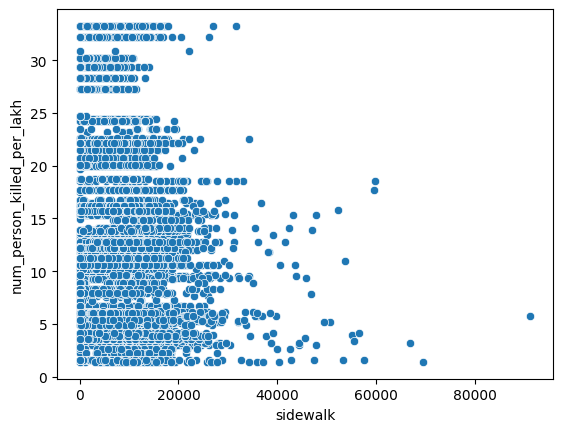

In [34]:
sns.scatterplot(
    data = seg_sample_fatality[(seg_sample_fatality["res"]==9)&(seg_sample_fatality["person"]>500)],
    x = "sidewalk",
    y = "num_person_killed_per_lakh",
    # hue = "Country"
)

In [59]:
for res in [8,9,12]:
    seg_sample_fatality[seg_sample_fatality["res"].isin([res])].to_csv(os.path.join(EXPORT_FOLDER, f"01_seg_dalys_long_res={res}.csv"), index = False)

## 3. For each city's analysis unit